# LangGraph implementation

In [1]:
from langchain_core.tools import tool
from langchain_openai.chat_models import ChatOpenAI

from langgraph.prebuilt import ToolNode
from langgraph.graph import StateGraph, MessagesState, START, END

from nlp.NLSPipeline import extract_nutritional_features
from models.dev.faiss_indexes import FlatIndex

from dotenv import load_dotenv
from typing import Dict

# Load env
load_dotenv()

# Load index
index = FlatIndex("../../recipe_embeddings.json")

/Users/Anaqi_Amir/opt/anaconda3/envs/FlavorFusion/lib/python3.11/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
2025-03-18 09:37:35.246403: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/Users/Anaqi_Amir/opt/anaconda3/envs/FlavorFusion/lib/python3.11/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


## Test this Code

In [ ]:
from typing import Annotated, List, Dict, Any, Optional, TypedDict

from langchain_core.messages import HumanMessage, AIMessage
from langchain_openai import ChatOpenAI
from langchain.tools import tool
from langchain.agents import AgentExecutor, create_react_agent, create_tool_calling_agent
from langchain import hub
from langgraph.graph import StateGraph, START, END
# from langgraph.prebuilt import ToolNode, FunctionGraph
from langchain_core.runnables import RunnablePassthrough
from langchain_core.messages import BaseMessage
from langchain_core.agents import AgentAction
from langchain_core.prompts import ChatPromptTemplate
from pydantic import BaseModel

from langgraph.graph.message import add_messages

import operator


# Define your tools
@tool
def recommend_recipes(q: str) -> str:
    """Takes in user input, extracts relevant features, and output recommended recipes from database"""

    print(f"\n Parsed user input: \n {q} \n")

    extracted_features = extract_nutritional_features(q)

    print(f"\n Extracted features: \n {extracted_features} \n")

    recs = index.recommend_recipes(
        user_ingredients=extracted_features.user_ingredients,
        allergens=extracted_features.allergens,
        calories=extracted_features.calories,
        total_fat=extracted_features.total_fat,
        protein=extracted_features.protein,
        saturated_fat=extracted_features.saturated_fat,
        carbs=extracted_features.carbs,
        sodium=extracted_features.sodium,
        sugar=extracted_features.sugar,
        top_n=10,
    )

    print(f"\n recs: \n {recs} \n")

    return ", ".join(recs)

@tool
def final_answer(answer: str) -> str:
    """Useful for providing the final answer to the user."""
    return answer

tools = [recommend_recipes, final_answer]

# Define the LLM
llm = ChatOpenAI(temperature=0.7)

# Define the agent
# prompt = hub.pull("hwchase17/react")
# agent = create_react_agent(llm, tools, prompt)
# agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)

# Define the agent
prompt = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """
            You are a recipe recommendation program that takes in user inputs
            and outputs a list of recipes. If a user does not provide enough information
            on what recipes they want, you will keep on asking them about it until
            you have enough information to get a good recommendation for the user.
            """,
        ),
        ("placeholder", "{chat_history}"),
        ("human", "{query}"),
        ("placeholder", "{agent_scratchpad}"),
    ]
)

agent = create_tool_calling_agent(
    llm=llm,
    prompt=prompt,
    tools=tools
)

agent_executor = AgentExecutor(agent=agent, tools=tools, verbose=True)


# Define the LangGraph state
class AgentState(TypedDict):
    def __init__(self, messages: List[Any], ingredients: Optional[str] = None, nutrition: Optional[str] = None, recipes: Optional[str] = None):
        self.messages = messages
        self.ingredients = ingredients
        self.nutrition = nutrition
        self.recipes = recipes

# Define the nodes
def agent_node(state: AgentState) -> Dict:
    # result = agent_executor.invoke({"input": state.messages[-1].content, "chat_history": state.messages[:-1]})
    query = state.messages[-1].content
    print(query)
    result = agent_executor.invoke({"query": query, "chat_history": state.messages[:-1]})
    return {"messages": state.messages + [AIMessage(content=result["output"])]}

def recommendation_node(state: AgentState):
    result = recommend_recipes.run(ingredients=state.ingredients, nutrition=state.nutrition)
    return {"messages": state.messages + [AIMessage(content=f"Here are some recommended recipes: {result}")], "recipes": result}

def final_answer_node(state: AgentState) -> Dict:
    result = final_answer.run(answer=state.messages[-1].content)
    return {"messages": state.messages + [AIMessage(content=result)]}


# Define router
def router(state: AgentState):
    if "recommend_recipes" in state.message[-1].content:
        return "recommend"
    elif "final_answer" in state.messages[-1].content:
        return "final"
    else:
        return "agent"

# Define the graph
workflow = StateGraph(AgentState)
workflow.add_node("agent", agent_node)
workflow.add_node("recommendation_tool", recommendation_node)
workflow.add_node("final_answer_tool", final_answer_node)

# Set up the edges
workflow.add_edge(START, "agent")
workflow.add_conditional_edges(
    "agent",
    router,
    {
        "recommend": "recommendation_tool",
        "final": "final_answer_tool",
        "agent": "agent"
    }
)
# workflow.add_edge("recommendation_tool", "final_answer_tool")
workflow.add_edge("final_answer_tool", END)

# Compile the graph
app = workflow.compile()

# Example usage
inputs = {
    "messages": [HumanMessage(content="I'm looking for healthy recipes with chicken and low carbs.")],
    "ingredients": "chicken, garlic, honey",
    "nutrition": "High protein",
    "recipes": "Honey garlic chicken"
}
# inputs = AgentState(
#     messages = ["I'm looking for healthy recipes with chicken and low carbs"],
#     ingredients = 'chicken',
#     nutrition = "high protein",
#     recipes = None
# )
inputs = {
    "query": "please give me a chicken recipe"
}
print(inputs)
print(type(inputs))
result = app.invoke(inputs)
print(result)

# inputs2 = {"messages": [HumanMessage(content="Hi, how are you?")]}
# result2 = app.invoke(inputs2)
# print(result2)

# inputs3 = {"messages": [HumanMessage(content="I need recipes with beef and high protein")]}
# result3 = app.invoke(inputs3)
# print(result3)

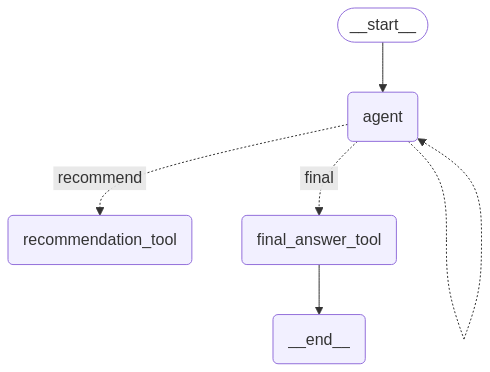

In [3]:
from IPython.display import Image, display
try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    pass

In [ ]:
# This agent works
agent_executor.invoke({"query": "Hi please give me a chicken recipe", "chat_history": [""]})



> Entering new AgentExecutor chain...

Invoking: `recommend_recipes` with `{'q': 'chicken'}`



 Parsed user input: 
 chicken 



/Users/Anaqi_Amir/Desktop/FlavorFusion/api/src/nlp/NLSPipeline.py:91: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  llm = ChatOpenAI(temperature=0.1, api_key=os.environ.get("OPENAI_API_KEY"))
/Users/Anaqi_Amir/Desktop/FlavorFusion/api/src/nlp/NLSPipeline.py:94: LangChainDeprecationWarning: The class `LLMChain` was deprecated in LangChain 0.1.17 and will be removed in 1.0. Use :meth:`~RunnableSequence, e.g., `prompt | llm`` instead.
  chain = LLMChain(llm=llm, prompt=chat_prompt)



 Extracted features: 
 user_ingredients=['chicken'] allergens=[] calories=(None, None) total_fat=(None, None) saturated_fat=(None, None) carbs=(None, None) sugar=(None, None) sodium=(None, None) protein=(None, None) 


 recs: 
 ['old fashioned chicken noodle soup', 'feel better chicken noodle soup', 'corn and  broccoli bake', 'grandma s chicken and rice soup', 'swanson sensational chicken noodle soup', 'minnesota cream of chicken   wild rice soup', 'chicken rice hot dish', 'easy swanson chicken noodle soup', 'chicken tortilla soup  quick', 'creamy slow cooker chicken'] 

old fashioned chicken noodle soup, feel better chicken noodle soup, corn and  broccoli bake, grandma s chicken and rice soup, swanson sensational chicken noodle soup, minnesota cream of chicken   wild rice soup, chicken rice hot dish, easy swanson chicken noodle soup, chicken tortilla soup  quick, creamy slow cooker chickenI have found some chicken recipes for you:
1. Old Fashioned Chicken Noodle Soup
2. Feel Better C

{'query': 'Hi please give me a chicken recipe',
 'chat_history': [''],
 'output': "I have found some chicken recipes for you:\n1. Old Fashioned Chicken Noodle Soup\n2. Feel Better Chicken Noodle Soup\n3. Corn and Broccoli Bake\n4. Grandma's Chicken and Rice Soup\n5. Swanson Sensational Chicken Noodle Soup\n6. Minnesota Cream of Chicken & Wild Rice Soup\n7. Chicken Rice Hot Dish\n8. Easy Swanson Chicken Noodle Soup\n9. Chicken Tortilla Soup (Quick)\n10. Creamy Slow Cooker Chicken\n\nLet me know if you would like more details on any of these recipes!"}

# IGNORE BELOW

In [15]:
@tool("recipe_recommender")
def recipe_recommender(q: str) -> Dict:
    """Takes in user input, extracts relevant features, and output recommended recipes from database"""

    print(f"\n Parsed user input: \n {q} \n")

    extracted_features = extract_nutritional_features(q)

    print(f"\n Extracted features: \n {extracted_features} \n")

    recs = index.recommend_recipes(
        user_ingredients=extracted_features.user_ingredients,
        allergens=extracted_features.allergens,
        calories=extracted_features.calories,
        total_fat=extracted_features.total_fat,
        protein=extracted_features.protein,
        saturated_fat=extracted_features.saturated_fat,
        carbs=extracted_features.carbs,
        sodium=extracted_features.sodium,
        sugar=extracted_features.sugar,
        top_n=10,
    )

    print(f"\n recs: \n {recs} \n")

    return {"messages": recs}


@tool("final_answer")
def final_answer(recommendations: str) -> str:
    """Formats the query into a final answer"""
    print("im in final_answer tool")
    return recommendations


tools = [recipe_recommender, final_answer]
tool_node = ToolNode(tools)


def router(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    print(f"Last message: {last_message}")
    if last_message.tool_calls:
        return "recommender"
    return END


def chatbot(state: MessagesState):
    messages = state["messages"]
    response = llm.invoke(messages)
    print("hi im here")
    return {"messages": [response]}


llm = ChatOpenAI(
    model="gpt-3.5-turbo",
    temperature=0.25,
    max_tokens=500
).bind_tools(tools)

output = tool_node.invoke(
    {
        "messages": [
            llm.invoke(
                # "Recommend me a recipe with around 500 calories, low fat (no more than 10g total fat), high protein, \n"
                # "and please avoid macadamia nuts and whey protein. I love tomatoes and basil, but I don't like onions."
                "What do I do here?"
            )
        ],
    }
)

print(output)

{'messages': []}
